<a href="https://colab.research.google.com/github/18430349/medmnist-image-classification/blob/main/FYP_w1840439.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INSTALLATION AND LOADING LIBRARIES

## Installation

In [1]:
#Here I am installing the necessary library
!pip install medmnist tensorflow streamlit imbalanced-learn

## Libraries

In [2]:
# Standard Libraries
import numpy as np  # For numerical operations like arrays and matrices
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For visuals
import seaborn as sns  # For statistical plots
import cv2  # For working with images
import random  # Useful for generating randomness in dataset
from PIL import Image  # For image files; opening and saving
import streamlit as st # For web interface

# TensorFlow / Keras Libraries7
import tensorflow as tf #For training and building ML models
from tensorflow.keras import models, layers, regularizers #Tensorflow/Keras function
from tensorflow.keras.models import Sequential, Model #For neural network
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, GlobalAveragePooling2D,Resizing) #For pre-processing, building the model architecture
from tensorflow.keras.optimizers import Adam #This is the optimiser for fine tuning the model
from tensorflow.keras.applications import ResNet50 #For pre-trained model
from tensorflow.keras.applications.resnet50 import preprocess_input #Pre-process images for ResNet50 model
from tensorflow.keras.preprocessing.image import ImageDataGenerator #For augmentation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau ##Stops training when model doesnt pimprove
from tensorflow.keras.layers import BatchNormalization


# Sklearn Libraries
from sklearn.model_selection import train_test_split #For splitting dataset
from sklearn.preprocessing import StandardScaler  # For feature scaling
from sklearn.linear_model import LogisticRegression #For Logistic Regression classification model
from sklearn.svm import SVC #This is for Support vector machine classification model
from sklearn.utils.class_weight import compute_class_weight # For computing class weight for unbalanced class
from sklearn.metrics import (classification_report,confusion_matrix,accuracy_score) #For model performance evaluation

# MedMNIST dataset
from medmnist import INFO, Evaluator  # Metadata and evaluation tools
from medmnist import BreastMNIST #Load the data

#Others
from imblearn.over_sampling import SMOTE  # For handling unbalanced datasets
import torch
import torchvision.transforms as transforms

## Loading Dataset

In [3]:
# Here I am loading the Breast Cancer dataset from MedMNIST (28x28 grayscale)
train_data = BreastMNIST(split='train', download=True, as_rgb=False)
val_data = BreastMNIST(split='val', download=True,as_rgb=False)
test_data = BreastMNIST(split='test', download=True,as_rgb=False)

In [4]:
# Extracting the images and labels
X_train, y_train = train_data.imgs, train_data.labels
X_val, y_val = val_data.imgs, val_data.labels
X_test, y_test = test_data.imgs, test_data.labels

# DATA EXPLORATION & PREPROCESSING

In [5]:
# Retrieving the dataset info for BreastMNIST
dataset_info = INFO['breastmnist']

# Checking what the 'label' field in the metadata contains
print("Class names in the BreastMNIST dataset:")
print(dataset_info['label'])

Class names in the BreastMNIST dataset:
{'0': 'malignant', '1': 'normal, benign'}


## Pre-proccessing

In [6]:
# Checking the shapes of the images and labels in the train, validation, and test datasets
print("Shape of training data:", X_train.shape, y_train.shape)
print("Shape of validation data:", X_val.shape, y_val.shape)
print("Shape of test data:", X_test.shape, y_test.shape)


Shape of training data: (546, 28, 28) (546, 1)
Shape of validation data: (78, 28, 28) (78, 1)
Shape of test data: (156, 28, 28) (156, 1)


They both match! So good to proceed.

In [7]:
#Squeezing label to 1d array
y_train = y_train.squeeze().astype(int)
y_val   = y_val.squeeze().astype(int)
y_test  = y_test.squeeze().astype(int)

In [8]:
#Checking for any duplicate images
def count_duplicates(images):
    reshaped_images = images.reshape(images.shape[0], -1)
    return pd.DataFrame(reshaped_images).duplicated().sum()

print(f" Duplicate images in Training Set: {count_duplicates(X_train)}")
print(f" Duplicate images in Validation Set: {count_duplicates(X_val)}")
print(f" Duplicate images in Testing Set: {count_duplicates(X_test)}")

 Duplicate images in Training Set: 0
 Duplicate images in Validation Set: 0
 Duplicate images in Testing Set: 0


No duplicates! Lets proceed to next step.

In [9]:
# Checking the class balance in train, val and test set
# Flatten the labels to 1D and check the class distribution
print("Class distribution in Training Set:")
print(pd.Series(y_train.ravel()).value_counts())

print("\nClass distribution in Validation Set:")
print(pd.Series(y_val.ravel()).value_counts())

print("\nClass distribution in Testing Set:")
print(pd.Series(y_test.ravel()).value_counts())

Class distribution in Training Set:
1    399
0    147
Name: count, dtype: int64

Class distribution in Validation Set:
1    57
0    21
Name: count, dtype: int64

Class distribution in Testing Set:
1    114
0     42
Name: count, dtype: int64


Severe imbalance for Malignant calsses!

Later I will be computing the class weight for the models because it works best with class weights. And only applying to the train dataset.

##Image Exploration

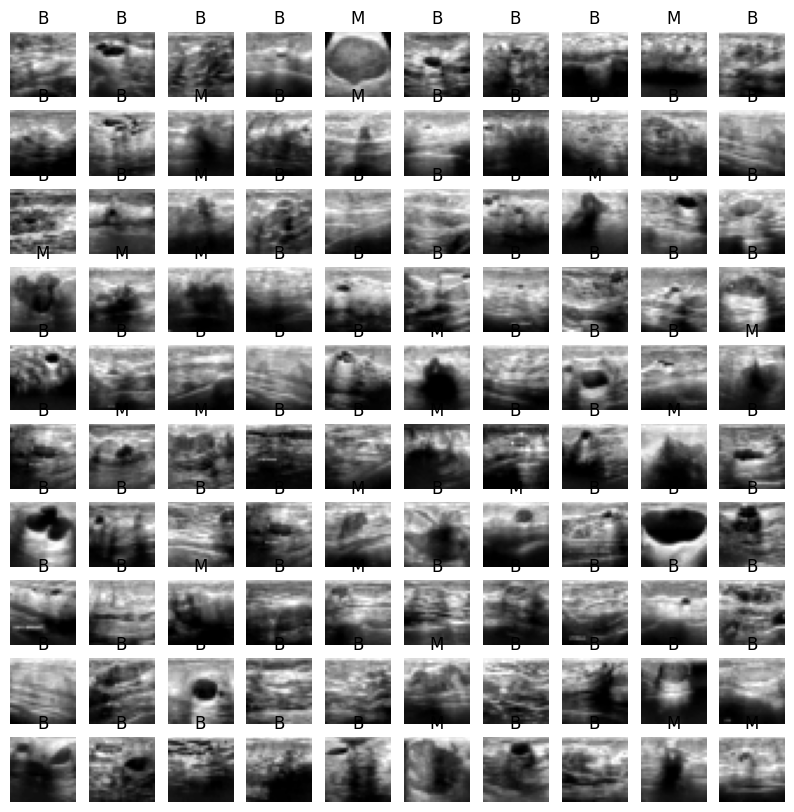

In [10]:
# Show a 10x10 montage of images from X_train
plt.figure(figsize=(10, 10))

# Loop through and plot the first 100 images
for i in range(100):  # Show 100 images
    plt.subplot(10, 10, i + 1)  # 10 rows, 10 columns
    plt.title('B' if y_train[i] == 1 else 'M')
    plt.axis('off')
    plt.imshow(X_train[i], cmap='gray')
    plt.axis('off')

plt.show()

These are the images we have in the training dataset. Some of them looks similar.But we have already clarified that they are all unique images!

Now lets check the test dataset!

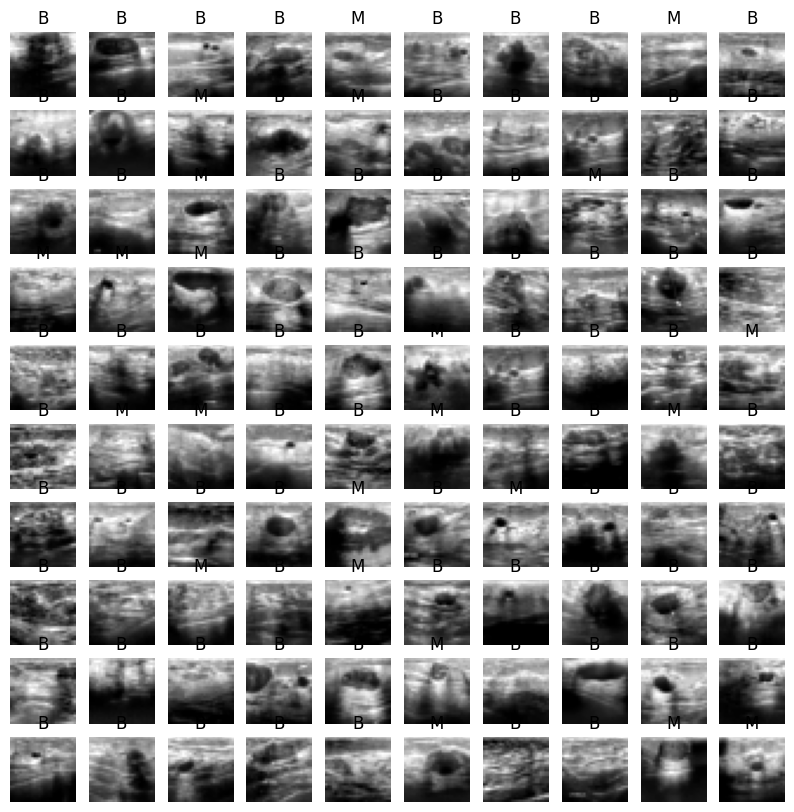

In [11]:
# Show a 10x10 montage of images from X_test
plt.figure(figsize=(10, 10))

# Loop through and plot the first 100 images
for i in range(100):  # Show 100 images
    plt.subplot(10, 10, i + 1)  # 10 rows, 10 columns
    plt.title('B' if y_train[i] == 1 else 'M')
    plt.axis('off')
    plt.imshow(X_test[i], cmap='gray')
    plt.axis('off')

plt.show()

Lets check the Validation set!

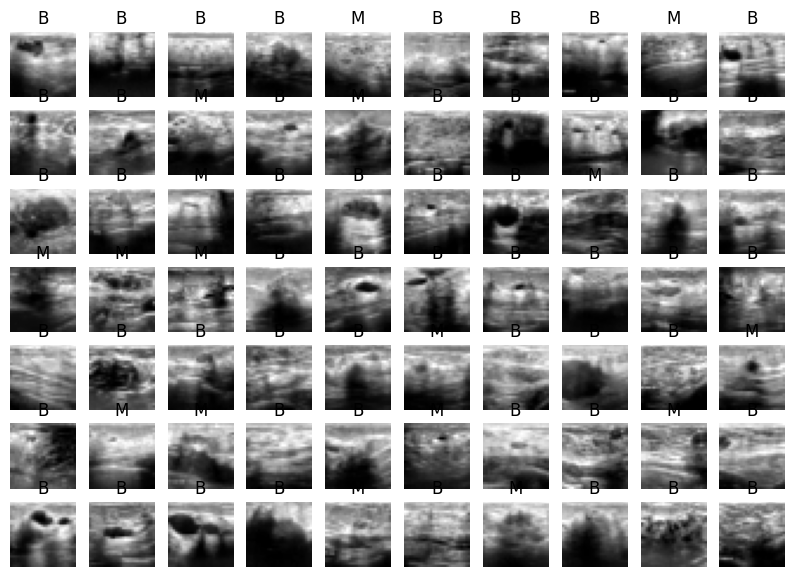

In [12]:
# Only can view 70 because the set only has 78.
plt.figure(figsize=(10, 10))

# Loop through and plot the first 70 images
for i in range(70):
    plt.subplot(10, 10, i + 1)
    plt.title('B' if y_train[i] == 1 else 'M')
    plt.axis('off')
    plt.imshow(X_val[i], cmap='gray')
    plt.axis('off')

plt.show()

Good! Lets proceed.

## Statistical View

In [13]:
# Extracting images below
malignant_images = X_train[y_train.flatten() == 0]
benign_images = X_train[y_train.flatten() == 1]

Lets calculate mean pixels of each image for both classes and visualise it!

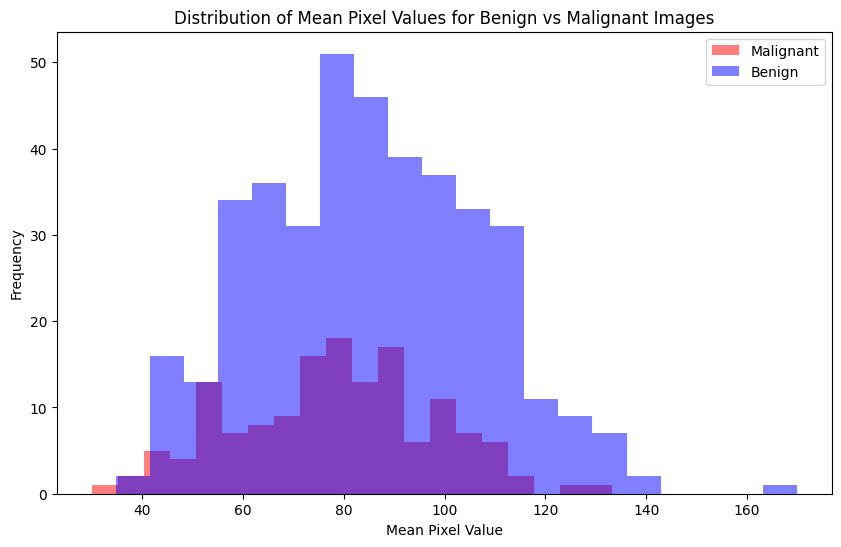

In [14]:
# Calculating the mean pixel values for both classes here
mean_malignant = np.mean(malignant_images, axis=(1, 2))  # Mean of each image (for all pixels)
mean_benign = np.mean(benign_images, axis=(1, 2))

# Plot histograms to compare the distribution of mean pixel values
plt.figure(figsize=(10, 6))

# Plot for malignant images
plt.hist(mean_malignant, bins=20, alpha=0.5, label='Malignant', color='red')
# Plot for benign images
plt.hist(mean_benign, bins=20, alpha=0.5, label='Benign', color='blue')

# Add labels and title
plt.title("Distribution of Mean Pixel Values for Benign vs Malignant Images")
plt.xlabel("Mean Pixel Value")
plt.ylabel("Frequency")
plt.legend()

plt.show()


Lets calculate an average of all the images and visualise it!

In [15]:
# Finding here the mean pixel values for benign and malignant images
mean_benign = np.mean(benign_images, axis=(0, 1, 2))
mean_malignant = np.mean(malignant_images, axis=(0, 1, 2))

print(f"Mean pixel value (benign): {mean_benign}")
print(f"Mean pixel value (malignant): {mean_malignant}")

Mean pixel value (benign): 85.50526187918777
Mean pixel value (malignant): 78.17982090795502


Not big difference but may be useful for deep researchs!

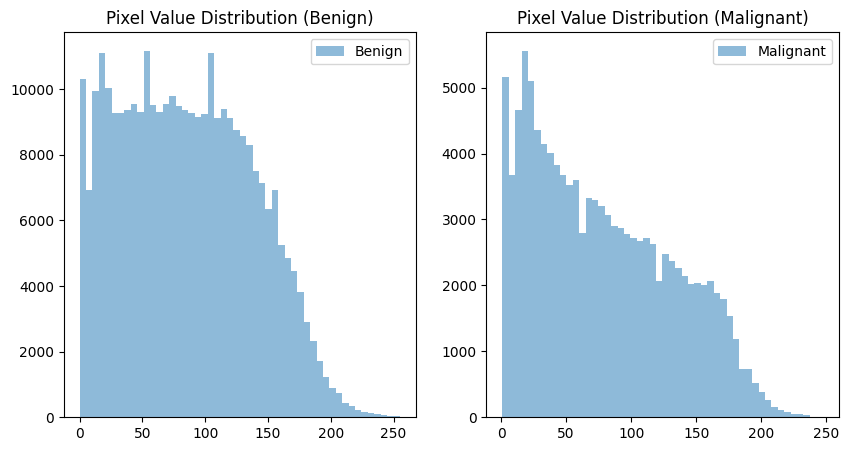

In [16]:
#Plot to view
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.hist(malignant_images.flatten(), bins=50, alpha=0.5, label='Malignant')
plt.title("Pixel Value Distribution (Malignant)")
plt.legend()

plt.subplot(1, 2, 1)
plt.hist(benign_images.flatten(), bins=50, alpha=0.5, label='Benign')
plt.title("Pixel Value Distribution (Benign)")
plt.legend()

plt.show()

## Data Augmentation

In [17]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(28, 28, 1)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    ])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


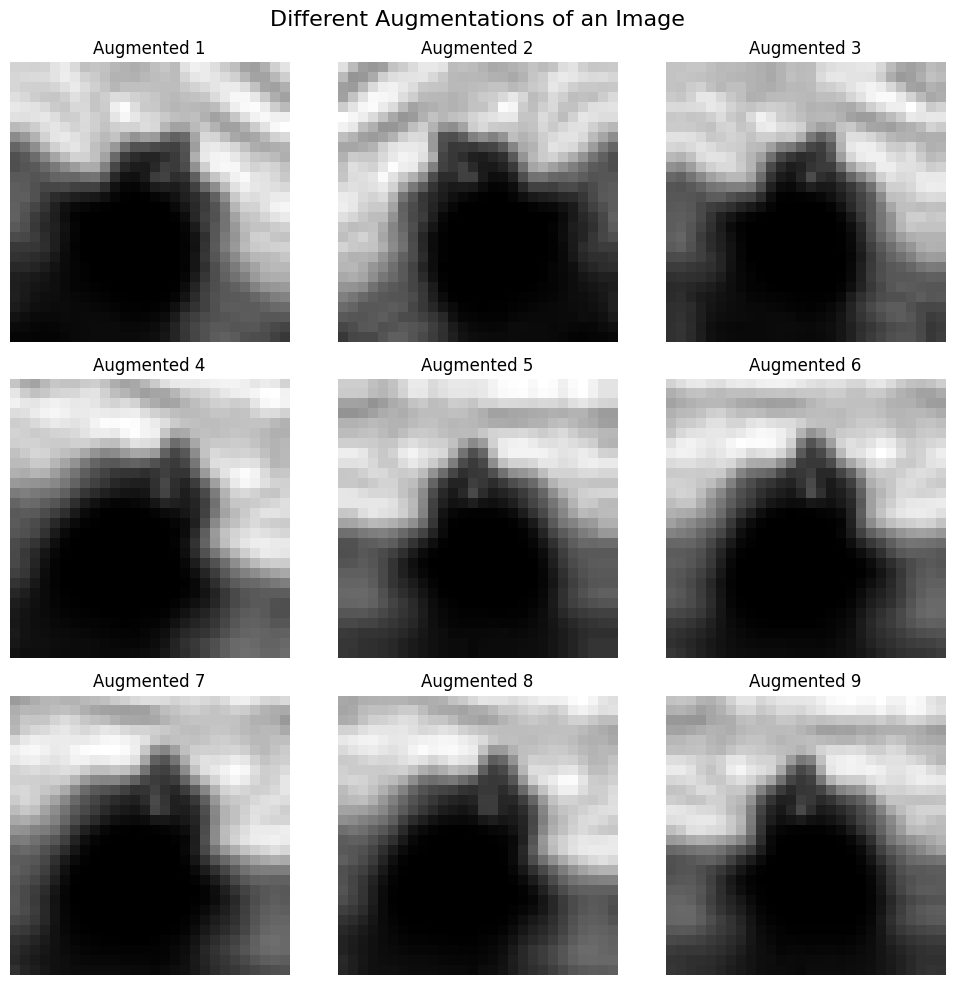

In [18]:
# Pick a random image
rand_idx = random.randint(0, len(X_train) - 1)
sample_image = np.expand_dims(X_train[rand_idx], axis=0)

# Plot multiple augmented versions
plt.figure(figsize=(10, 10))

for i in range(9):
    # Apply augmentation
    augmented_image = data_augmentation(sample_image, training=True)

    # Plot
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().squeeze(), cmap='gray')
    plt.title(f'Augmented {i+1}')
    plt.axis('off')

plt.suptitle('Different Augmentations of an Image', fontsize=16)
plt.tight_layout()
plt.show()

# MODEL

## Data formatting

Lets check the train set before and after normalisation!

In [19]:
print(X_train)

[[[139 139 138 ... 165 162 165]
  [ 84  92  94 ... 124 116 112]
  [ 84  82  87 ... 124 127 126]
  ...
  [ 63  70  83 ...  36  34  32]
  [ 59  70  73 ...  50  40  34]
  [ 62  65  61 ...  51  42  40]]

 [[ 82  85  83 ...  76  83  86]
  [ 80  82  68 ...  59  61  64]
  [ 56  59  60 ...  59  58  60]
  ...
  [ 24  23  19 ...  18  18  17]
  [ 23  21  16 ...  24  23  19]
  [ 22  24  18 ...  26  22  19]]

 [[157 155 151 ... 130 128 131]
  [160 162 156 ... 126 126 135]
  [129 119 122 ... 114 110 110]
  ...
  [ 67  66  63 ...  77  75  71]
  [ 74  70  72 ...  80  82  76]
  [ 85  81  73 ...  77  79  72]]

 ...

 [[159 160 167 ... 134 136 143]
  [144 147 144 ... 123 128 143]
  [120 129 140 ... 119 101  99]
  ...
  [ 54  55  53 ...  52  44  40]
  [ 50  53  51 ...  43  46  51]
  [ 57  52  51 ...  50  55  56]]

 [[ 55  57  61 ...  59  62  64]
  [ 63  72  78 ...  68  70  71]
  [ 51  50  64 ...  61  50  57]
  ...
  [ 12  12  13 ...  19  19  19]
  [ 13  12  14 ...  17  18  18]
  [ 12  12  15 ...  14  15  

Here we can see the raw pixel values and the intensities are in the 0 to 255 range typical of grayscale images.

Next Im converting the images from integer type to float32 and scale them by dividing by 255.0. Because of this normalization maps pixel values to the range 0, 1 and helps for faster processs.

In [20]:
#Normalisation to improve training
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

#print to the normalisation
print("X_train shape:", X_train)

X_train shape: [[[0.54509807 0.54509807 0.5411765  ... 0.64705884 0.63529414 0.64705884]
  [0.32941177 0.36078432 0.36862746 ... 0.4862745  0.45490196 0.4392157 ]
  [0.32941177 0.32156864 0.34117648 ... 0.4862745  0.49803922 0.49411765]
  ...
  [0.24705882 0.27450982 0.3254902  ... 0.14117648 0.13333334 0.1254902 ]
  [0.23137255 0.27450982 0.28627452 ... 0.19607843 0.15686275 0.13333334]
  [0.24313726 0.25490198 0.23921569 ... 0.2        0.16470589 0.15686275]]

 [[0.32156864 0.33333334 0.3254902  ... 0.29803923 0.3254902  0.3372549 ]
  [0.3137255  0.32156864 0.26666668 ... 0.23137255 0.23921569 0.2509804 ]
  [0.21960784 0.23137255 0.23529412 ... 0.23137255 0.22745098 0.23529412]
  ...
  [0.09411765 0.09019608 0.07450981 ... 0.07058824 0.07058824 0.06666667]
  [0.09019608 0.08235294 0.0627451  ... 0.09411765 0.09019608 0.07450981]
  [0.08627451 0.09411765 0.07058824 ... 0.10196079 0.08627451 0.07450981]]

 [[0.6156863  0.60784316 0.5921569  ... 0.50980395 0.5019608  0.5137255 ]
  [0.62

So, now the values are between 0 and 1.
Its format is ready for training the model!

In [21]:
print("X_train shape before reshaping:", X_train.shape)
print("X_val shape before reshaping:", X_val.shape)
print("X_test shape before reshaping:", X_test.shape)

X_train shape before reshaping: (546, 28, 28)
X_val shape before reshaping: (78, 28, 28)
X_test shape before reshaping: (156, 28, 28)


In [22]:
# Reshaping the data to add dimension
X_train_cnn = X_train.reshape(-1, 28, 28, 1) #using the smote balanced labels
X_test_cnn = X_test.reshape(-1, 28, 28, 1)
X_val_cnn = X_val.reshape(-1, 28, 28, 1)

y_train_cnn = y_train #using the smote balanced labels

In [23]:
print (X_train_cnn.shape)
print (X_val_cnn.shape)
print (X_test_cnn.shape)
print (y_train_cnn.shape)

(546, 28, 28, 1)
(78, 28, 28, 1)
(156, 28, 28, 1)
(546,)


## Neural Network

In [24]:
# NN model architecture
def nn_model():
  model = Sequential([
      Input(shape=(28, 28, 1)),
      #data_augmentation,
      layers.Conv2D(16, (3, 3), activation='relu'),  # Extract features
      layers.BatchNormalization(), #Normalise activations
      layers.MaxPooling2D((2, 2)),  # Reduces dimension
      layers.Dropout(0.2),

      layers.Conv2D(32, (3, 3), activation='relu'), # Deeper feature extraction
      layers.BatchNormalization(),
      layers.MaxPooling2D((2, 2)),
      layers.Dropout(0.2),

      layers.Conv2D(64, (3, 3), activation='relu'), # Deeper feature extraction
      layers.BatchNormalization(),
      layers.MaxPooling2D((2, 2)),

      layers.Flatten(),  # Converts feature maps to 1D,
      layers.Dropout(0.5),
      layers.Dense(128, activation='relu'),  # Fully connected hidden layer
      layers.Dense(1, activation='sigmoid') #Sigmoid for binary output
      ])

  #Compiling model
  model.compile(optimizer=Adam (learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [25]:
cnn_model= nn_model()
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 3, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,193 (125.75 KB)

 Trainable params: 31,969 (124.88 KB)

 Non-trainable params: 224 (896.00 B)

In [26]:
classes = np.unique(y_train_cnn)
weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train_cnn
)
class_weight_dict = dict(zip(classes, weights))

# Training the CNN model
history_cnn=cnn_model.fit(
    X_train_cnn, y_train_cnn,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_cnn, y_val),
    class_weight=class_weight_dict,
    )

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.5908 - loss: 0.8528 - val_accuracy: 0.6154 - val_loss: 0.6915
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.6108 - loss: 0.7413 - val_accuracy: 0.7436 - val_loss: 0.6848
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.6316 - loss: 0.7048 - val_accuracy: 0.7308 - val_loss: 0.6760
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.6336 - loss: 0.6696 - val_accuracy: 0.7564 - val_loss: 0.6778
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7050 - loss: 0.6425 - val_accuracy: 0.7308 - val_loss: 0.6795
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6895 - loss: 0.6409 - val_accuracy: 0.7308 - val_loss: 0.6813
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7346 - loss: 0.5614 - val_accuracy: 0.5641 - val_loss: 0.6877
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7019 - loss: 0.5848 - val_accuracy: 0.6026 - 

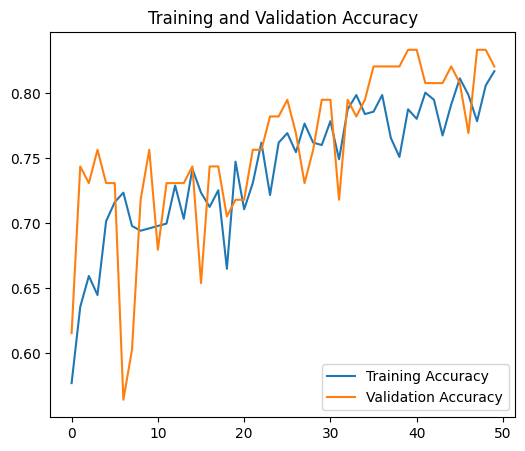

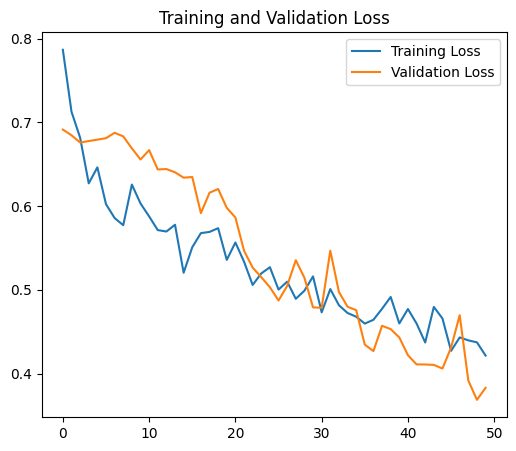

In [27]:
#Accuracy /Loss Plots
epochs_range = range(50)

acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']

plt.figure(figsize=(6, 5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

print()

loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

plt.figure(figsize=(6, 5))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


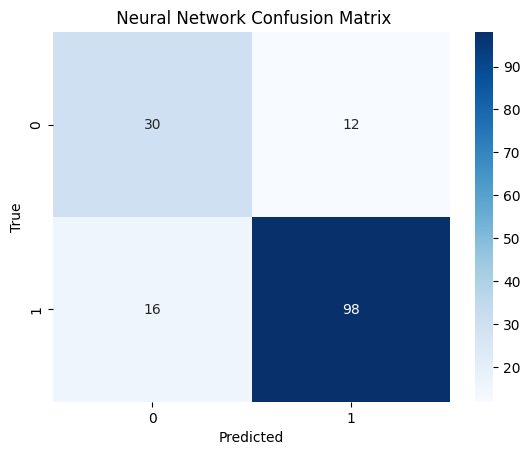

In [29]:
plot_cm(y_test, cnn_model.predict(X_test_cnn).round(), " Neural Network Confusion Matrix")

In [30]:
print("Neural Network Classification Report:")
print(classification_report(y_test, cnn_model.predict(X_test_cnn).flatten().round()))


Neural Network Classification Report:
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
              precision    recall  f1-score   support

           0       0.65      0.71      0.68        42
           1       0.89      0.86      0.88       114

    accuracy                           0.82       156
   macro avg       0.77      0.79      0.78       156
weighted avg       0.83      0.82      0.82       156



##SVM

Flattening images for SVM and Logistic Regression

In [31]:
#Here it converts each image into a 1D vector for compatability for SVM
X_train_flat = X_train.reshape(-1, 28*28)
X_val_flat = X_val.reshape(-1, 28*28)
X_test_flat = X_test.reshape(-1, 28*28)

In [32]:
# Initialising the SVM model
svm_model = SVC(kernel='linear', class_weight='balanced')

# Train the SVM model
svm_model.fit(X_train_flat, y_train)

SVC(class_weight='balanced', kernel='linear')

In [33]:
#Predicting using SVM
svm_predictions = svm_model.predict(X_test_flat)

SVM Model Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.67      0.60        42
           1       0.87      0.79      0.83       114

    accuracy                           0.76       156
   macro avg       0.70      0.73      0.71       156
weighted avg       0.78      0.76      0.76       156



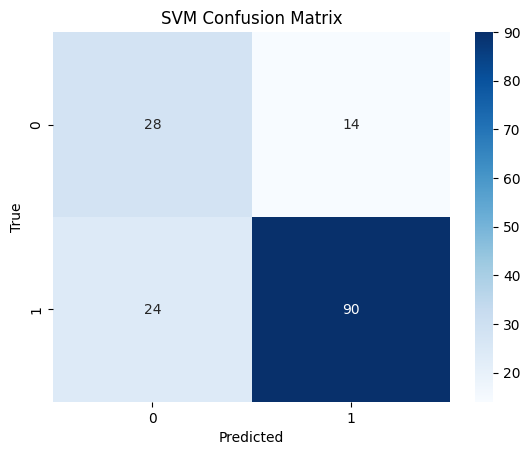

In [34]:
# Evaluation of the SVM model
print("SVM Model Classification Report:")
print(classification_report(y_test, svm_predictions))

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plotting the confusion matrix for SVM
plot_cm(y_test, svm_predictions, "SVM Confusion Matrix")

## Logistic Regression

In [35]:
# Initialising the Logistic Regression model
log_reg_model = LogisticRegression(class_weight='balanced', max_iter=1000)

# Train the Logistic Regression model
log_reg_model.fit(X_train_flat, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [36]:
#This is for predicting using Logistic Regression
log_reg_predictions = log_reg_model.predict(X_test_flat)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.71      0.65        42
           1       0.89      0.82      0.85       114

    accuracy                           0.79       156
   macro avg       0.74      0.77      0.75       156
weighted avg       0.81      0.79      0.79       156



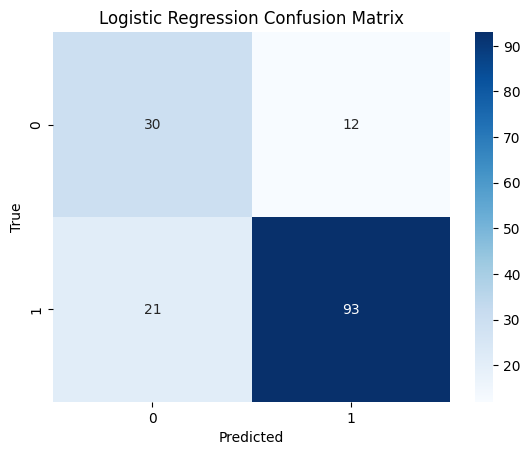

In [37]:
# Evaluation of the Logistic Regression model
print("Logistic Regression Classification Report:")
print(classification_report(y_test, log_reg_predictions))

# Plotting the confusion matrix for Logistic Regression
plot_cm(y_test, log_reg_predictions, "Logistic Regression Confusion Matrix")

# ADVANCED MODEL

In [38]:
# Here making sure the grayscale images are float32 in [0,1]
X_train = X_train.astype('float32') / 255.0
X_val   = X_val.astype('float32')   / 255.0
X_test  = X_test.astype('float32')  / 255.0

# Adding the channel axis and repeat to make RGB
#  Now the shape is (N, 28, 28, 1) which will turn to (N, 28, 28, 3)
X_train_rgb = np.repeat(X_train[..., np.newaxis], 3, axis=-1)
X_val_rgb   = np.repeat(X_val[...,   np.newaxis], 3, axis=-1)
X_test_rgb  = np.repeat(X_test[...,  np.newaxis], 3, axis=-1)

#Resizing to 32×32
X_train_resized = tf.image.resize(X_train_rgb, (32, 32))
X_val_resized   = tf.image.resize(X_val_rgb,   (32, 32))
X_test_resized  = tf.image.resize(X_test_rgb,  (32, 32))

#Scaling back to [0,255] since ResNet50 was trained on ImageNet in that range
X_train_resized = X_train_resized * 255.0
X_val_resized   = X_val_resized   * 255.0
X_test_resized  = X_test_resized  * 255.0

#Then apply the model specific preprocessing
X_train_preprocessed = preprocess_input(X_train_resized)
X_val_preprocessed   = preprocess_input(X_val_resized)
X_test_preprocessed  = preprocess_input(X_test_resized)

In [39]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [40]:
y_train = y_train.squeeze().astype(int)

In [41]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)


Class weights: {0: np.float64(1.8571428571428572), 1: np.float64(0.6842105263157895)}


Now, its ready to be fed!

In [42]:
# Defining ResNet50 model with pre-trained weights (ImageNet)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freezing the base model layers
base_model.trainable = False
for layer in base_model.layers:[-20]
layer.trainable=True

# Adding the custom layers on top
model_resnet = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.Dense(128),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])


In [43]:
# Compile the model
model_resnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [44]:
model_resnet= model_resnet
model_resnet.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 1, 1, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,146,817 (92.11 MB)

 Trainable params: 558,337 (2.13 MB)

 Non-trainable params: 23,588,480 (89.98 MB)

In [45]:
# Train the ResNet model
history_res50 = model_resnet.fit(
    X_train_preprocessed, y_train,
    epochs=10,
    validation_data=(X_val_preprocessed, y_val),
    batch_size=16
)

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 28s 373ms/step - accuracy: 0.6092 - loss: 0.7222 - val_accuracy: 0.7308 - val_loss: 0.6702
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.7527 - loss: 0.5268 - val_accuracy: 0.7308 - val_loss: 0.5616
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - accuracy: 0.7590 - loss: 0.5146 - val_accuracy: 0.7308 - val_loss: 0.6161
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.7606 - loss: 0.5139 - val_accuracy: 0.7308 - val_loss: 0.5187
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.7364 - loss: 0.5314 - val_accuracy: 0.7308 - val_loss: 0.6072
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.7424 - loss: 0.4901 - val_accuracy: 0.7949 - val_loss: 0.5518
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.7311 - loss: 0.5600 - val_accuracy: 0.7308 - val_loss: 0.5430
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.7730 - loss: 0.4736 - val_accuracy: 0.7

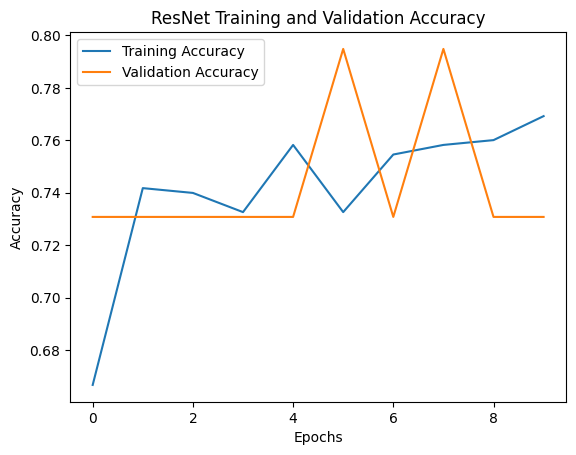

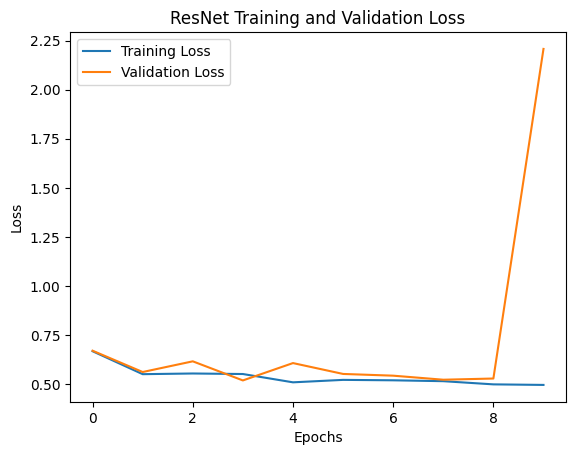

In [46]:
# Plotting Training and Validation Accuracy
plt.plot(history_res50.history['accuracy'], label='Training Accuracy')
plt.plot(history_res50.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print()

#Plotting Loss
plt.plot(history_res50.history['loss'], label='Training Loss')
plt.plot(history_res50.history['val_loss'], label='Validation Loss')
plt.title('ResNet Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.7136 - loss: 2.2622
Test Accuracy for ResNet: 0.7308
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 832ms/step


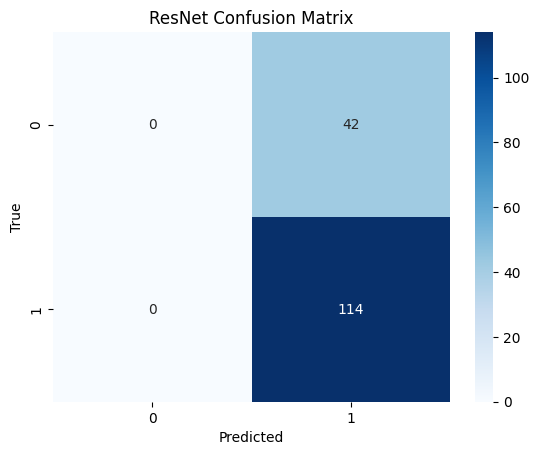

ResNet Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.73      1.00      0.84       114

    accuracy                           0.73       156
   macro avg       0.37      0.50      0.42       156
weighted avg       0.53      0.73      0.62       156



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [47]:
# Evaluate the model on the test data
test_loss, test_acc = model_resnet.evaluate(X_test_preprocessed, y_test)
print(f"Test Accuracy for ResNet: {test_acc:.4f}")

# Plot confusion matrix for ResNet
y_pred_resnet = (model_resnet.predict(X_test_preprocessed) > 0.5).astype(int)
plot_cm(y_test, y_pred_resnet, "ResNet Confusion Matrix")

#Classification report
print("ResNet Classification Report:")
print(classification_report(y_test, y_pred_resnet))

# MODEL EVALUATION

In [48]:
print("Neural Network Classification Report:")
print(classification_report(y_test, cnn_model.predict(X_test_cnn).flatten().round()))

print("SVM Classification Report:")
print(classification_report(y_test, svm_predictions))

print("Logistic Regression Classification Report:")
print(classification_report(y_test, log_reg_predictions))

print("ResNet50 Classification Report:")
print(classification_report(y_test, model_resnet.predict(X_test_preprocessed).flatten().round()))

Neural Network Classification Report:
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
              precision    recall  f1-score   support

           0       0.65      0.71      0.68        42
           1       0.89      0.86      0.88       114

    accuracy                           0.82       156
   macro avg       0.77      0.79      0.78       156
weighted avg       0.83      0.82      0.82       156

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.67      0.60        42
           1       0.87      0.79      0.83       114

    accuracy                           0.76       156
   macro avg       0.70      0.73      0.71       156
weighted avg       0.78      0.76      0.76       156

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.71      0.65        42
           1       0.89      0.82      0.85       114

    accuracy                        

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# DEPLOYMENT

In [49]:
#Saving the model in keras format
cnn_model.save('breast_cancer_cnn_model.keras')


In [50]:
from google.colab import files
files.download("breast_cancer_cnn_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
app_code = """
import streamlit as st
from PIL import Image
import numpy as np
import cv2
from tensorflow.keras.models import load_model

# For loading the trained model
model = load_model("path of the model")

# Setting the page configuration with default styling
st.set_page_config(page_title="Breast Cancer Tumor Classifier", layout="wide")

# Sidebar with a welcome message and upload instructions
st.sidebar.title("Welcome")
st.sidebar.write("Please upload your ultrasound image here.")

# Main title and instructions
st.title("Breast Cancer Tumor Classifier")
st.write("Upload an ultrasound image of a breast tumor. The input image will be checked for validity and appropriate resolution.")

# File uploader
uploaded_image = st.file_uploader("Upload Ultrasound Image", type=["jpg", "jpeg", "png"])

def is_valid_image(uploaded_file):

# To check if the uploaded file is a valid image.

    try:
        # Attempt to open and verify the image.
        img = Image.open(uploaded_file)
        img.verify()
        return True
    except Exception:
        return False

if uploaded_image is not None:
    if not is_valid_image(uploaded_image):
        st.error("The uploaded file is not a valid image. Please upload a valid ultrasound image.")
    else:
        try:
            # Open the image for further processing
            image = Image.open(uploaded_image)
            st.image(image, caption="Uploaded Image", use_column_width=True)
            st.write("Preprocessing the image...")

            # Convert image to grayscale
            image = image.convert('L')
            image_array = np.array(image)

            # Check that image dimensions are reasonable
            if image_array.shape[0] < 28 or image_array.shape[1] < 28:
                st.error("Image dimensions are too small. Please upload an ultrasound image with sufficient resolution.")
            else:
                # Resize image to the required 28x28
                processed_image = cv2.resize(image_array, (28, 28))

                # Prepare the image for the neural network model: add channel dimension and normalize
                processed_image = processed_image.reshape(1, 28, 28, 1).astype('float32') / 255.0

                # Load the pretrained neural network model
                model = load_model("breast_cancer_cnn_model.keras")

                with st.spinner('Processing...'):
                    prediction = model.predict(processed_image)

                confidence = prediction[0][0]
                result = "Benign" if confidence > 0.5 else "Malignant"
                st.write(f"Prediction: **{result}**")
                st.write(f"Confidence: **{(confidence if result == 'Benign' else 1 - confidence) * 100:.2f}%**")
                st.success('Done!')
        except Exception as e:
            st.error(f"Error processing the image: {e}")
else:
    st.info("Please upload an ultrasound image to get started.")"""

# Write to file
with open("app.py", "w") as f:
    f.write(app_code)


In [52]:
#Downloading the app.py for visula studios for web interface
files.download("app.py")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>